# 0. Install and Import dependencies

In [1]:
!pip install tensorflow stable-baselines3[extra] gymnasium

In [1]:
import gymnasium as gym
from gymnasium import spaces

# Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Load BTCUSD Data 
https://www.coingecko.com/it/monete/bitcoin/historical_data?start=2025-01-01&end=2025-05-26
https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data?mod=mw_quote_t


In [2]:
# Load DataFrame
df_processed = pd.read_csv('data/BTCUSD_processed.csv')

print("First rows of the dataframe:")
print(df_processed.head(15))

First rows of the dataframe:
          date   open   high    low  close        volume           sma  \
0   2022-12-18  16706  16798  16669  16760  1.508638e+10  17151.083333   
1   2022-12-19  16760  16832  16531  16595  1.113405e+10  17131.833333   
2   2022-12-20  16595  17046  16288  16862  1.771967e+10  17103.833333   
3   2022-12-21  16861  16924  16738  16780  2.493822e+10  17077.083333   
4   2022-12-22  16780  16863  16566  16781  1.606277e+10  17044.416667   
5   2022-12-23  16780  16917  16764  16804  1.784783e+10  17019.333333   
6   2022-12-24  16804  16854  16763  16842  1.676539e+10  16996.083333   
7   2022-12-25  16842  16851  16734  16768  1.016985e+10  16914.083333   
8   2022-12-26  16768  16912  16766  16839  1.257445e+10  16836.083333   
9   2022-12-27  16839  16962  16601  16655  1.257500e+10  16772.416667   
10  2022-12-28  16655  16772  16560  16589  1.743606e+10  16748.416667   
11  2022-12-29  16588  16650  16468  16596  1.911361e+10  16739.250000   
12  2022-

# 2. Build Environment

In [3]:
# This function creates a normalized observation vector for the agent at a given timestep
def get_normalized_observation(df_processed,  # your full DataFrame (with engineered features)
                               current_idx,    # the current timestep index
                               window_size,    # how many past days to include in the observation
                               volume_scaler,  # scaler fit on log(volume)
                               long_term_feature_scalers,  # dictionary of scalers for long-term features
                               portfolio_state=None):  # dictionary with balance, btc_held, etc. (optional)

    start_idx = current_idx - window_size + 1  # compute the starting index of the sliding window
    if start_idx < 0:
        raise IndexError("Not enough data for the observation window.")

    window_df = df_processed.iloc[start_idx: current_idx + 1]  # slice of the df that represents the window
    first_close = window_df['close'].iloc[0]

    # Compute features derived from prices
    if abs(first_close) < 1e-9:  # if it's too close to 0
        close_norm = np.zeros(window_size, dtype=np.float32)
        sma_norm = np.zeros(window_size, dtype=np.float32)
    else:
        close_norm = (window_df['close'].values / first_close) - 1.0
        sma_norm = (window_df['sma'].values / first_close) - 1.0

    # Replace high/low with % difference from close
    high_diff = ((window_df['high'] - window_df['close']) / window_df['close']).values
    low_diff = ((window_df['low'] - window_df['close']) / window_df['close']).values

    price_features = [high_diff, low_diff, close_norm, sma_norm]

    # Normalize volume: apply log transform, then scale to [0, 1]
    if 'volume_log' not in window_df.columns:
        window_df = window_df.copy()
        window_df['volume_log'] = np.log1p(window_df['volume'])
    normalized_volume = volume_scaler.transform(window_df[['volume_log']]).flatten()

    # Normalize RSI (0–1 scale)
    normalized_rsi = window_df['rsi'].values / 100.0

    # Normalize long-term features from the current day
    current_features = df_processed.iloc[current_idx]
    normalized_long_term = [
        scaler.transform(pd.DataFrame({name: [current_features[name]]}))[0, 0]
        for name, scaler in long_term_feature_scalers.items()
    ]

    # NEW: Mean feature correlation in the current window (simple proxy)
    corr_window = df_processed.iloc[start_idx: current_idx + 1][['close', 'sma', 'rsi', 'volume_log']]
    corr_matrix = corr_window.corr().abs()
    mean_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).mean().mean()
    correlation_feature = np.array([mean_corr], dtype=np.float32)

    # NEW: Add normalized portfolio state (net_worth, balance, btc_held, etc.)
    if portfolio_state is not None:
        portfolio_vector = np.array([
            portfolio_state['net_worth'],
            portfolio_state['balance'],
            portfolio_state['btc_held'],
            portfolio_state['btc_shorted'],
            portfolio_state['current_position']
        ], dtype=np.float32) / portfolio_state['initial_balance']
    else:
        portfolio_vector = np.zeros(5, dtype=np.float32)

    # Combine all into one observation vector
    observation = np.concatenate([
        np.concatenate(price_features),
        normalized_volume,
        normalized_rsi,
        np.array(normalized_long_term),
        correlation_feature,
        portfolio_vector
    ])
    return observation.astype(np.float32)

## 2.2 Create New Environments

In [4]:
class BitcoinTradingEnv(gym.Env):  # OpenAI Gym environment
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    # Constructor
    def __init__(self,
                 df,  # historical data: OHLCV and features
                 window_size,  # how many days of history the agent observes
                 initial_balance,  # starting cash in USD
                 volume_scaler, long_term_feature_scalers,  # for normalizing volume + long-term indicators
                 transaction_cost_pct=0.0):  # optional transaction cost (default is 0)
        
        super().__init__()
        
        # Store parameters
        self.df = df
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.volume_scaler = volume_scaler
        self.long_term_feature_scalers = long_term_feature_scalers
        self.transaction_cost_pct = transaction_cost_pct

        # Small reward for taking action (trade or hold)
        self.action_reward = 0.0001

        # Define action space: 0 = Buy, 1 = Sell, 2 = Hold
        self.action_space = spaces.Discrete(3)

        # Compute observation vector length
        self.obs_vector_length = (4 * window_size) + window_size + window_size + len(long_term_feature_scalers) + 1 + 5

        # Continuous observation space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.obs_vector_length,), dtype=np.float32
        )

        # Initialize environment state
        self.reset()

    # Reset environment state to the beginning of an episode
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size - 1  # start after window to get full history
        self.balance = self.initial_balance
        self.btc_held = 0.0
        self.net_worth = self.initial_balance
        self.prev_price = self._get_current_price()
        self.buy_price = None
        self.short_price = None
        self.btc_shorted = 0.0
        self.current_position = 0  # 1 = long, -1 = short, 0 = neutral
        self.max_steps = len(self.df) - 1

        return self._get_observation(), self._get_info()

    # Get current market price (used throughout env logic)
    def _get_current_price(self):
        return self.df['close'].iloc[self.current_step]

    # Build the current observation vector
    def _get_observation(self):
        return get_normalized_observation(
            self.df, self.current_step, self.window_size,
            self.volume_scaler, self.long_term_feature_scalers,
            portfolio_state={  # portfolio state is now included in observation
                'net_worth': self.net_worth,
                'balance': self.balance,
                'btc_held': self.btc_held,
                'btc_shorted': self.btc_shorted,
                'current_position': self.current_position,
                'initial_balance': self.initial_balance
            }
        )

    # Returns environment state for debugging or tracking
    def _get_info(self):
        return {
            "step": self.current_step,
            "balance": self.balance,
            "btc_held": self.btc_held,
            "net_worth": self.net_worth,
            "current_price": self._get_current_price(),
            "btc_shorted": self.btc_shorted,
            "short_price": self.short_price,
            "current_position": self.current_position
        }

    # Step forward in time using the action provided by the agent
    def step(self, action):
        prev_net_worth = self.net_worth
        current_price = self._get_current_price()
        reward = 0.0

        # --- ACTION EXECUTION LOGIC ---
        if action == 0:  # BUY
            if self.btc_shorted > 0:
                # Closing short position
                cost_to_cover = self.btc_shorted * current_price
                short_profit = (self.short_price - current_price) * self.btc_shorted
                self.balance -= cost_to_cover
                self.balance += self.short_price * self.btc_shorted
                profit_pct = short_profit / (self.short_price * self.btc_shorted) if self.short_price > 0 else 0
                reward += profit_pct * 100
                reward += self.action_reward
                self.btc_shorted = 0.0
                self.short_price = None
                self.current_position = 0

            elif self.balance > 0:
                # Opening long position
                btc_bought = self.balance / current_price if current_price > 0 else 0
                self.btc_held += btc_bought
                self.balance = 0
                self.buy_price = current_price
                reward += self.action_reward
                self.current_position = 1

        elif action == 1:  # SELL
            if self.btc_held > 0:
                # Closing long position
                sell_value = self.btc_held * current_price
                self.balance += sell_value
                self.btc_held = 0
                if self.buy_price:
                    profit_pct = (current_price - self.buy_price) / self.buy_price
                    reward += profit_pct * 100
                reward += self.action_reward
                self.buy_price = None
                self.current_position = 0

            elif self.btc_shorted == 0:
                # Opening short position
                btc_shorted = (self.balance / 2) / current_price if current_price > 0 else 0
                self.btc_shorted = btc_shorted
                self.short_price = current_price
                reward += self.action_reward
                self.current_position = -1

        elif action == 2:  # HOLD
            reward += self.action_reward  # mildly reward the decision to hold

        # --- Update Portfolio State ---
        short_liability = self.btc_shorted * current_price
        self.net_worth = self.balance + self.btc_held * current_price - short_liability

        # Reward includes log-return reward to encourage profitable behavior
        if prev_net_worth > 0:
            reward += np.log(self.net_worth / prev_net_worth) # more stable across time, better suited to RL gradient update

        self.prev_price = current_price
        self.current_step += 1

        # --- Termination logic ---
        terminated = self.current_step >= self.max_steps or self.net_worth <= self.initial_balance * 0.1
        truncated = False  # no time limits here

        # Always return a valid observation, even after episode ends
        observation = (
            self._get_observation() if not terminated
            else np.zeros(self.observation_space.shape, dtype=np.float32)
        )

        info = self._get_info()
        if terminated:
            info["episode"] = {
                "r": float(self.net_worth - self.initial_balance),  # final profit/loss
                "l": self.current_step  # episode length
            }

        return observation, reward, terminated, truncated, info

    # Render the current step (for debugging)
    def render(self):
        print(f"Step: {self.current_step} | Net Worth: ${self.net_worth:.2f} | BTC Held: {self.btc_held:.6f} | Shorted: {self.btc_shorted:.6f} | Balance: ${self.balance:.2f}")

# 3. Training

In [5]:
# --- Add volume_log column (before splitting the dataset!) ---
df_processed['volume_log'] = np.log1p(df_processed['volume'])

# Parameters
WINDOW_SIZE = 30
INITIAL_BALANCE = 10000
TRANSACTION_COST = 0  # 0.001  # example value

# Split dataset
train_ratio = 0.8
split_idx = int(len(df_processed) * train_ratio)

df_train = df_processed.iloc[:split_idx].reset_index(drop=True)
df_test = df_processed.iloc[split_idx:].reset_index(drop=True)

# --- Fit scalers on training data only ---
volume_scaler = MinMaxScaler().fit(df_train[['volume_log']])
lt_features = ['distance_from_sma_200', 'position_in_200_range']  # removed 'volatility_100'
long_term_feature_scalers = {
    feat: StandardScaler().fit(df_train[[feat]]) for feat in lt_features
}

# Arguments for the environment constructor
train_env_args = dict(
    df=df_train,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

test_env_args = dict(
    df=df_test,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

def make_train_env():
    return BitcoinTradingEnv(**train_env_args)

def make_test_env():
    return BitcoinTradingEnv(**test_env_args)

# Vectorized Envs
train_vec_env = DummyVecEnv([make_train_env])
test_vec_env = DummyVecEnv([make_test_env])

In [6]:
def faster_schedule(initial_value: float, power: float = 2.0, min_lr: float = 0.0):
    def func(progress_remaining: float) -> float:
        decayed_value = (progress_remaining ** power) * initial_value
        current_lr = np.clip(decayed_value, min_lr, initial_value)
        return current_lr
    return func

In [7]:
# Define training parameters
initial_learning_rate = 0.001
decay_power = 2.0
minimum_learning_rate = 1e-6

tensorboard_log_dir = "./ppo_bitcoin_tensorboard/"
policy_kwargs = dict(net_arch=dict(pi=[64, 64], vf=[128, 128]))

model = PPO(
    "MlpPolicy",
    train_vec_env,
    verbose=1,
    learning_rate=faster_schedule(initial_learning_rate, power=decay_power, min_lr=minimum_learning_rate),
    policy_kwargs=policy_kwargs,
    tensorboard_log=tensorboard_log_dir
)

Using cpu device


In [8]:
# Training
TOTAL_TIMESTEPS = 2000000
print(f"Starting PPO training for {TOTAL_TIMESTEPS} timesteps...")
model.learn(total_timesteps=TOTAL_TIMESTEPS)
model.save("ppo_bitcoin_trader_2M_with_hold_and_state")

Starting PPO training for 2000000 timesteps...
Logging to ./ppo_bitcoin_tensorboard/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 691      |
|    ep_rew_mean     | -2.5e+03 |
| time/              |          |
|    fps             | 236      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 691         |
|    ep_rew_mean          | 1.1e+03     |
| time/                   |             |
|    fps                  | 235         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010020042 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss       

# 4. Testing

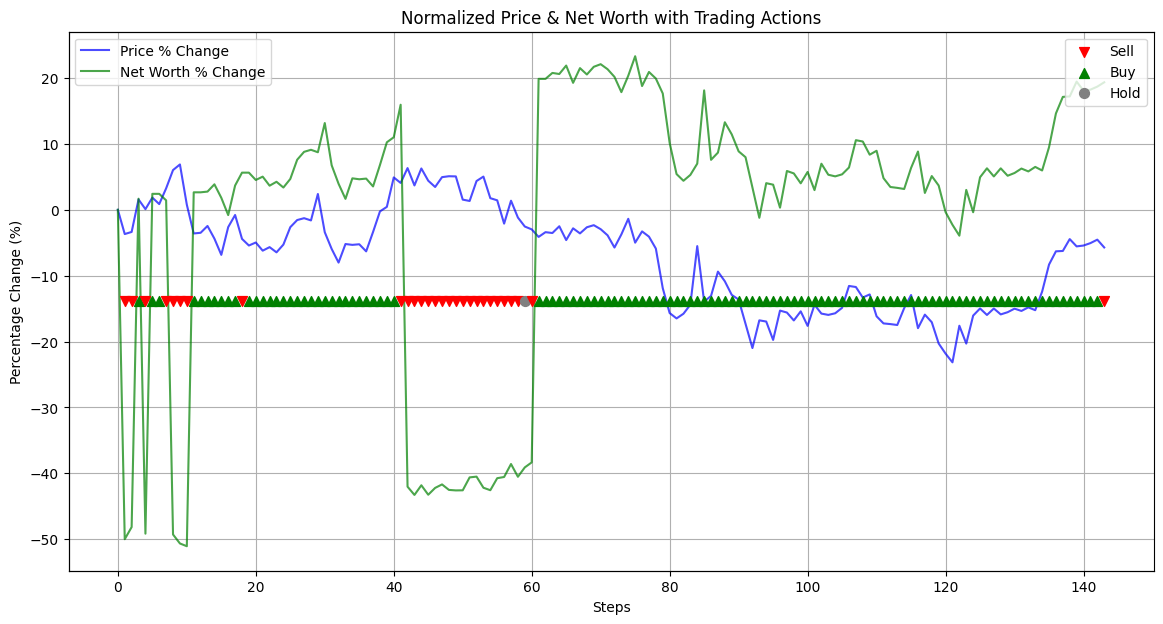

In [9]:
test_env = BitcoinTradingEnv(**test_env_args)
obs, info = test_env.reset()
done = False

net_worths = [info["net_worth"]]
prices = [info["current_price"]]
actions = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # Convert to int to fix unhashable type error
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    
    net_worths.append(info["net_worth"])
    prices.append(info["current_price"])
    actions.append(action)

actions = [None] + actions  # Align length with prices/net_worths

# Normalize price and net worth to percentage change from first value
price_pct = 100 * (np.array(prices) / prices[0] - 1)
net_worth_pct = 100 * (np.array(net_worths) / net_worths[0] - 1)

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(price_pct, label='Price % Change', color='blue', alpha=0.7)
ax1.plot(net_worth_pct, label='Net Worth % Change', color='green', alpha=0.7)
ax1.set_xlabel('Steps')
ax1.set_ylabel('Percentage Change (%)')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()

action_colors = {0: 'green', 1: 'red', 2: 'gray'}
action_labels = {0: 'Buy', 1: 'Sell', 2: 'Hold'}

# To avoid duplicate legend entries
plotted_labels = set()

for i, act in enumerate(actions):
    if act is not None:
        color = action_colors[act]
        label = action_labels[act] if act not in plotted_labels else None
        marker = '^' if act == 0 else 'v' if act == 1 else 'o'  # green arrow up = buy, red arrow down = sell, gray circle = hold
        ax2.scatter(i, 0, color=color, label=label, marker=marker, s=50)
        plotted_labels.add(act)

ax2.set_yticks([])
ax2.set_ylim(-1, 1)
ax2.spines['right'].set_visible(False)

ax2.legend(loc='upper right')

plt.title('Normalized Price & Net Worth with Trading Actions')
plt.show()

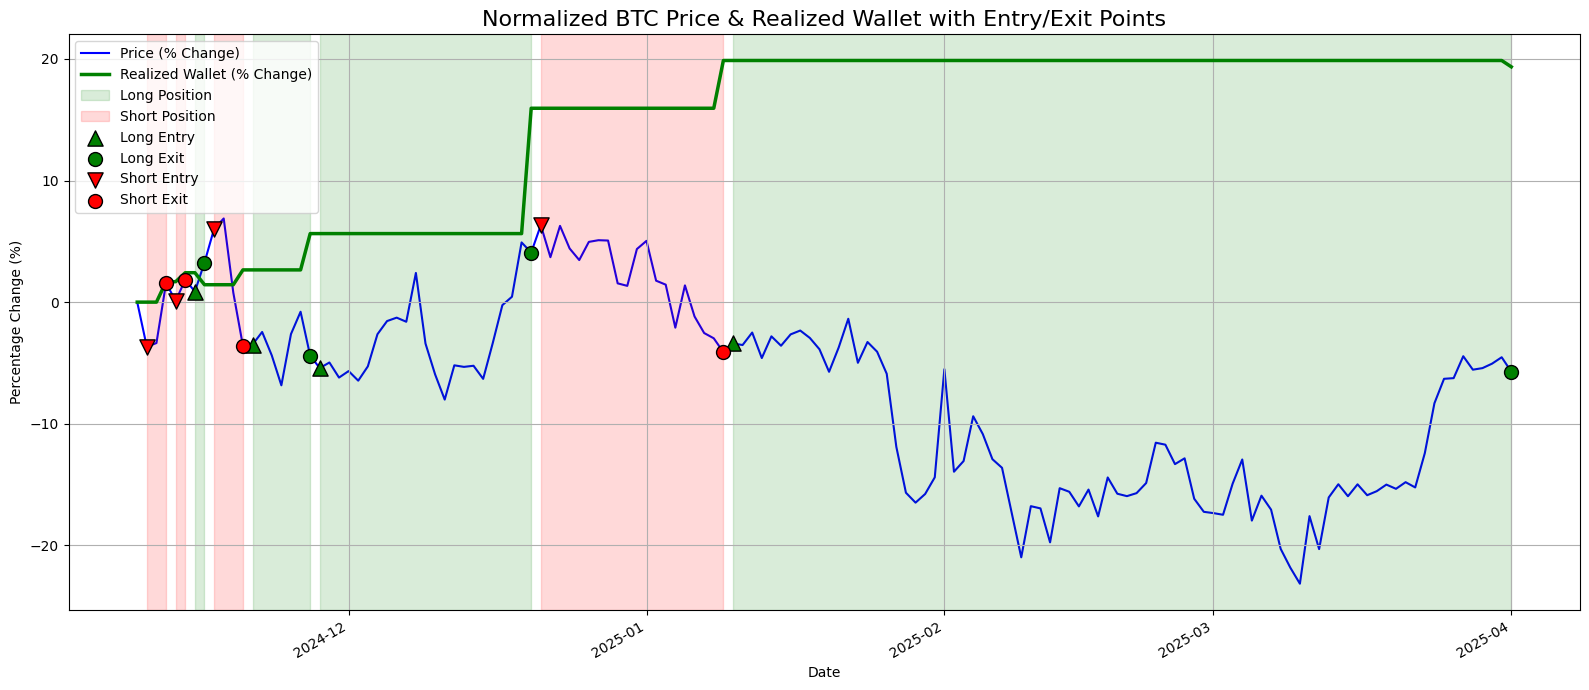

In [10]:
# --- Run trained model on test environment and track performance ---
test_env = BitcoinTradingEnv(**test_env_args)
obs, info = test_env.reset()
done = False

# Track price, net worth, and actions
net_worths = [info["net_worth"]]
prices = [info["current_price"]]
actions = []
positions = [info["current_position"]]

# Run policy
while not done:
    action, _ = model.predict(obs, deterministic=True)
    action = int(action)  # Ensure action is int, avoid unhashable errors
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    net_worths.append(info["net_worth"])
    prices.append(info["current_price"])
    actions.append(action)
    positions.append(info["current_position"])

# Add None to align actions with states
actions = [None] + actions

# --- Reconstruct position state ---
positions = []
current_position = 0
for action in actions:
    if action == 0:  # Buy
        if current_position == -1:
            current_position = 0  # Closing short
        elif current_position == 0:
            current_position = 1  # Opening long
    elif action == 1:  # Sell
        if current_position == 1:
            current_position = 0  # Closing long
        elif current_position == 0:
            current_position = -1  # Opening short
    # Hold (2) keeps the same position
    positions.append(current_position)

# --- Identify position transitions ---
long_entry_idx, long_exit_idx = [], []
short_entry_idx, short_exit_idx = [], []

for i in range(1, len(positions)):
    prev, curr = positions[i - 1], positions[i]
    if prev == 0 and curr == 1:
        long_entry_idx.append(i)
    elif prev == 1 and curr != 1:
        long_exit_idx.append(i)
    elif prev == 0 and curr == -1:
        short_entry_idx.append(i)
    elif prev == -1 and curr != -1:
        short_exit_idx.append(i)

# --- Build realized wallet curve ---
realized_net_worth = [net_worths[0]]
last_realized = net_worths[0]
prev_pos = positions[0]

for i in range(1, len(positions)):
    pos = positions[i]
    if prev_pos != 0 and (pos == 0 or np.sign(pos) != np.sign(prev_pos)):
        last_realized = net_worths[i]
    realized_net_worth.append(last_realized)
    prev_pos = pos

# Normalize for plotting
price_pct = 100 * (np.array(prices) / prices[0] - 1)
wallet_pct = 100 * (np.array(realized_net_worth) / realized_net_worth[0] - 1)

# Create timeline
dates = pd.date_range(start='2024-11-09', periods=len(prices), freq='D')

# --- Plotting ---
fig, ax = plt.subplots(figsize=(16, 7))

# Plot price and wallet %
ax.plot(dates, price_pct, label='Price (% Change)', color='blue', zorder=1)
ax.plot(dates, wallet_pct, label='Realized Wallet (% Change)', color='green', linewidth=2.5)

# Shaded position areas
def shade_position_periods(entry_idxs, color, label):
    for idx in entry_idxs:
        for j in range(idx + 1, len(positions)):
            if positions[j] != positions[idx]:
                ax.axvspan(dates[idx], dates[j], color=color, alpha=0.15, label=label if idx == entry_idxs[0] else "")
                break

shade_position_periods(long_entry_idx, 'green', 'Long Position')
shade_position_periods(short_entry_idx, 'red', 'Short Position')

# Entry/exit markers
ax.scatter(np.array(dates)[long_entry_idx], price_pct[long_entry_idx],
           marker='^', color='green', s=120, edgecolor='black', label='Long Entry', zorder=3)
ax.scatter(np.array(dates)[long_exit_idx], price_pct[long_exit_idx],
           marker='o', color='green', s=100, edgecolor='black', label='Long Exit', zorder=3)

ax.scatter(np.array(dates)[short_entry_idx], price_pct[short_entry_idx],
           marker='v', color='red', s=120, edgecolor='black', label='Short Entry', zorder=3)
ax.scatter(np.array(dates)[short_exit_idx], price_pct[short_exit_idx],
           marker='o', color='red', s=100, edgecolor='black', label='Short Exit', zorder=3)

# Format
ax.set_title('Normalized BTC Price & Realized Wallet with Entry/Exit Points', fontsize=16)
ax.set_ylabel('Percentage Change (%)')
ax.set_xlabel('Date')
ax.grid(True)
ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 4.b Testing on ETH

In [11]:
# Load ETH data
df_eth = pd.read_csv('data/ETHUSD_processed.csv')

# Add volume_log if missing
if 'volume_log' not in df_eth.columns:
    df_eth['volume_log'] = np.log1p(df_eth['volume'])

# ETH full test
df_eth_full = df_eth.copy().reset_index(drop=True)

# ETH test from specific date (e.g., 2024-11-09)
df_eth_cut = df_eth[df_eth['date'] >= '2024-11-09'].copy().reset_index(drop=True)

In [12]:
eth_env_args_full = dict(
    df=df_eth_full,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

eth_env_args_cut = dict(
    df=df_eth_cut,
    window_size=WINDOW_SIZE,
    initial_balance=INITIAL_BALANCE,
    volume_scaler=volume_scaler,
    long_term_feature_scalers=long_term_feature_scalers,
    transaction_cost_pct=TRANSACTION_COST
)

In [13]:
def test_and_plot_env(env_args, title_suffix=''):
    env = BitcoinTradingEnv(**env_args)

    obs, info = env.reset()
    done = False

    net_worths = [info["net_worth"]]
    prices = [info["current_price"]]
    actions = []
    positions = [info["current_position"]]

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))
        done = terminated or truncated

        net_worths.append(info["net_worth"])
        prices.append(info["current_price"])
        actions.append(int(action))
        positions.append(info["current_position"])

    actions = [None] + actions

    # Rebuild position tracking
    positions = []
    current_position = 0
    for action in actions:
        if action == 0:
            if current_position == -1:
                current_position = 0
            elif current_position == 0:
                current_position = 1
        elif action == 1:
            if current_position == 1:
                current_position = 0
            elif current_position == 0:
                current_position = -1
        positions.append(current_position)

    # Entry/exit points
    long_entry_idx, long_exit_idx = [], []
    short_entry_idx, short_exit_idx = [], []
    for i in range(1, len(positions)):
        prev, curr = positions[i - 1], positions[i]
        if prev == 0 and curr == 1:
            long_entry_idx.append(i)
        elif prev == 1 and curr != 1:
            long_exit_idx.append(i)
        elif prev == 0 and curr == -1:
            short_entry_idx.append(i)
        elif prev == -1 and curr != -1:
            short_exit_idx.append(i)

    # Realized wallet logic
    realized_net_worth = [net_worths[0]]
    last_val = net_worths[0]
    prev_pos = positions[0]
    for i in range(1, len(positions)):
        pos = positions[i]
        if prev_pos != 0 and (pos == 0 or np.sign(pos) != np.sign(prev_pos)):
            last_val = net_worths[i]
        realized_net_worth.append(last_val)
        prev_pos = pos

    price_pct = 100 * (np.array(prices) / prices[0] - 1)
    wallet_pct = 100 * (np.array(realized_net_worth) / realized_net_worth[0] - 1)

    steps = list(range(len(prices)))

    # Plot
    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(steps, price_pct, label='Price (% Change)', color='blue')
    ax.plot(steps, wallet_pct, label='Realized Wallet (% Change)', color='green', linewidth=2.5)

    def shade(idx_list, color, label):
        for idx in idx_list:
            for end in range(idx + 1, len(positions)):
                if positions[end] != positions[idx]:
                    ax.axvspan(idx, end, color=color, alpha=0.15, label=label if idx == idx_list[0] else "")
                    break

    shade(long_entry_idx, 'green', 'Long Position')
    shade(short_entry_idx, 'red', 'Short Position')

    ax.scatter(long_entry_idx, price_pct[long_entry_idx], marker='^', color='green', s=120, edgecolor='black', label='Long Entry', zorder=3)
    ax.scatter(long_exit_idx, price_pct[long_exit_idx], marker='o', color='green', s=100, edgecolor='black', label='Long Exit', zorder=3)

    ax.scatter(short_entry_idx, price_pct[short_entry_idx], marker='v', color='red', s=120, edgecolor='black', label='Short Entry', zorder=3)
    ax.scatter(short_exit_idx, price_pct[short_exit_idx], marker='o', color='red', s=100, edgecolor='black', label='Short Exit', zorder=3)

    ax.set_title(f'ETH: Price & Wallet % Change {title_suffix}', fontsize=16)
    ax.set_xlabel('Step')
    ax.set_ylabel('Percentage Change (%)')
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

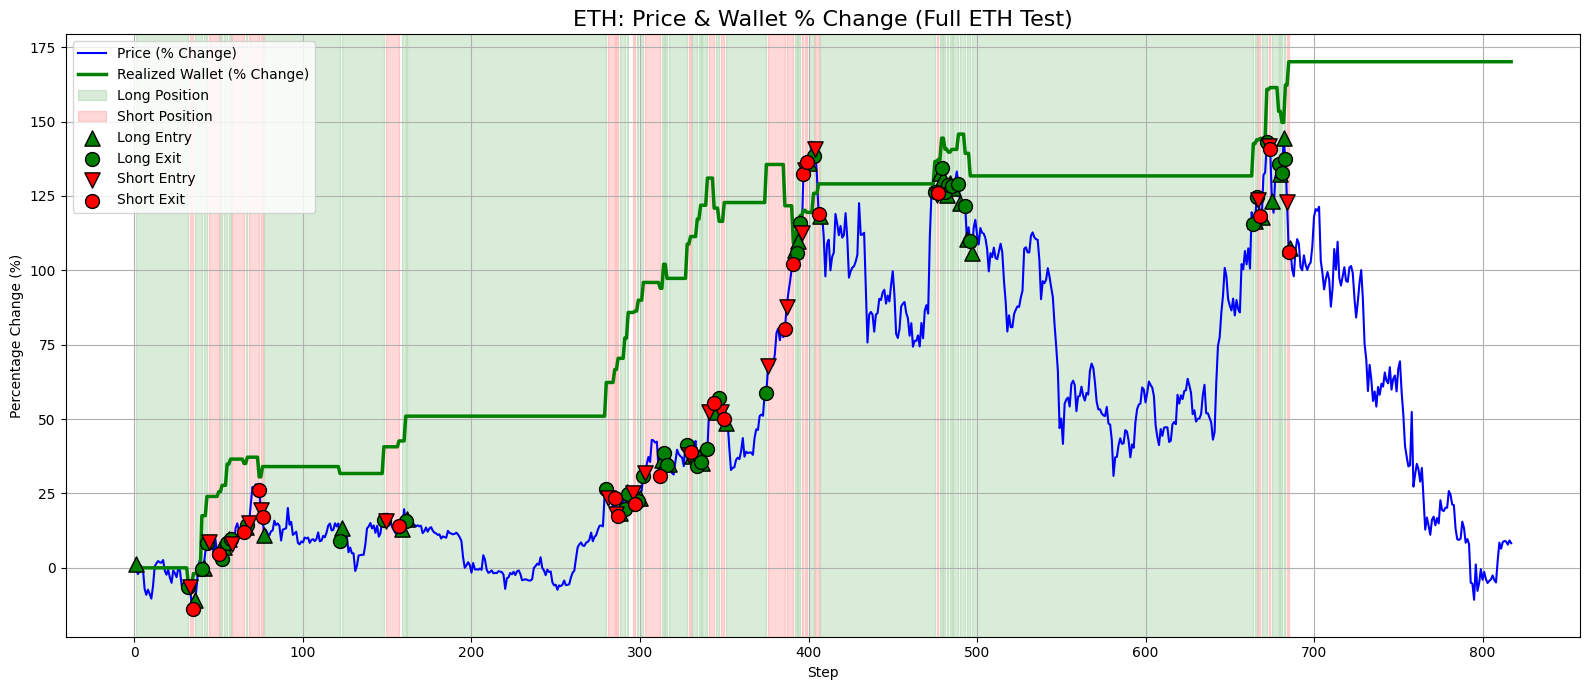

In [26]:
test_and_plot_env(eth_env_args_full, title_suffix='(Full ETH Test)')

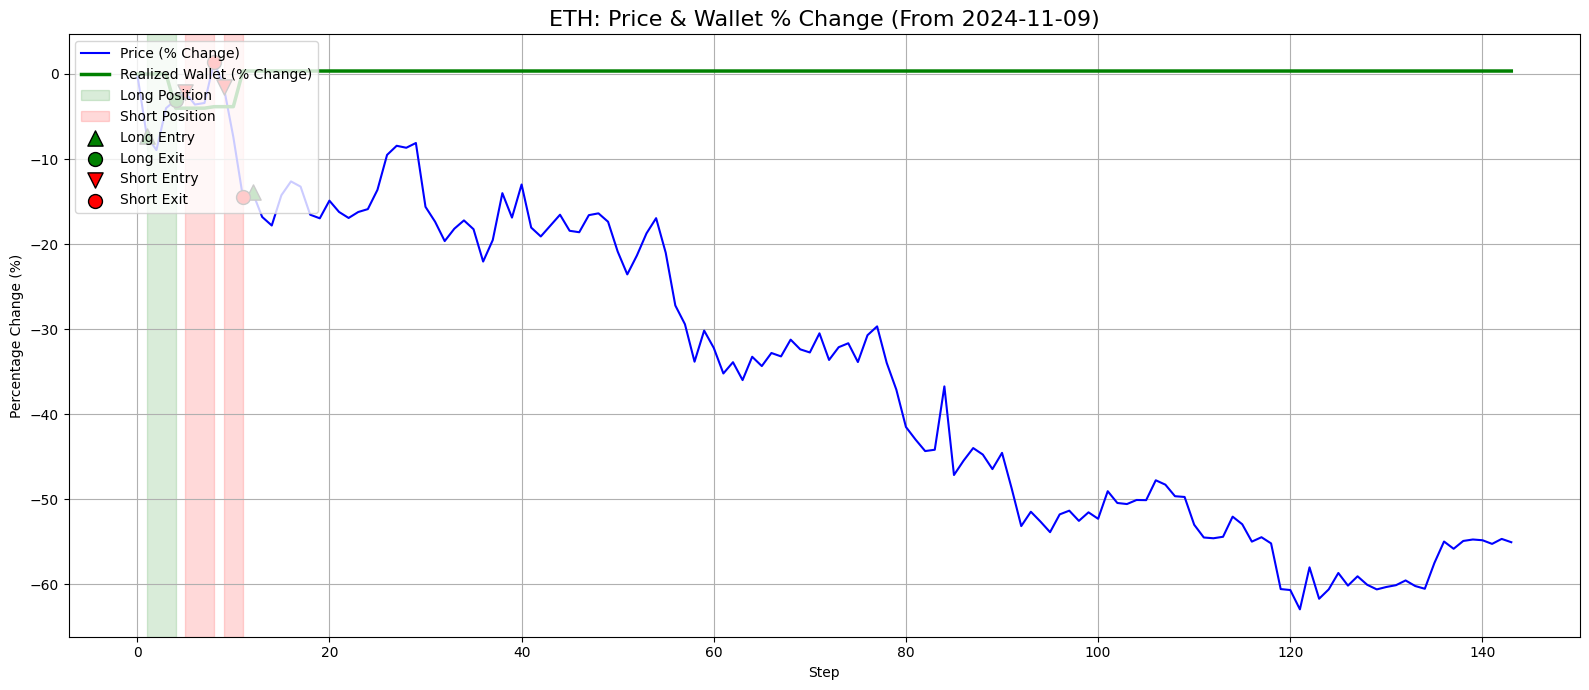

In [14]:
test_and_plot_env(eth_env_args_cut, title_suffix='(From 2024-11-09)')